# Data Splitting and preprocessing

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess data
def load_and_preprocess_data(data_directory):
    data = []    # To store images
    labels = []  # To store labels
    classes = 9  # Number of classes for traffic signs (0 to 8)

    for i in range(classes):
        path = os.path.join(data_directory, str(i))
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path, -1)
            image = cv2.resize(image, (30, 30), interpolation=cv2.INTER_NEAREST)
            data.append(image)
            labels.append(i)

    # Convert the lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# File locations for training and testing data
train_data_directory = '/content/drive/MyDrive/Indian Dataset/Train'
test_data_directory = '/content/drive/MyDrive/Indian Dataset/Test'

# Load and preprocess training data
X_train, y_train = load_and_preprocess_data(train_data_directory)

# Load and preprocess testing data
X_test, y_test = load_and_preprocess_data(test_data_directory)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Assuming you have 9 classes for traffic signs (0 to 8)
num_classes = 9

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Print the shapes after one-hot encoding
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)


X_train shape: (1318, 30, 30, 3)
y_train shape: (1318,)
X_test shape: (443, 30, 30, 3)
y_test shape: (443,)
y_train_one_hot shape: (1318, 10)
y_test_one_hot shape: (443, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ResNet

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Function to load and preprocess data
def load_and_preprocess_data(data_directory):
    data = []    # To store images
    labels = []  # To store labels
    classes = 9  # Number of classes for traffic signs (0 to 8)

    for i in range(classes):
        path = os.path.join(data_directory, str(i))
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path, -1)
            image = cv2.resize(image, (224, 224))  # Resize images for ResNet
            data.append(image)
            labels.append(i)

    # Convert the lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# File locations for training and testing data
train_data_directory = '/content/drive/MyDrive/Indian Dataset/Train'
test_data_directory = '/content/drive/MyDrive/Indian Dataset/Test'

# Load and preprocess training data
X_train, y_train = load_and_preprocess_data(train_data_directory)

# Load and preprocess testing data
X_test, y_test = load_and_preprocess_data(test_data_directory)

# Assuming you have 9 classes for traffic signs (0 to 8)
num_classes = 9

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Split training data into training and validation sets
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42
)

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a fully connected layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
# model_resnet.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/drive/MyDrive/Indian Dataset/model_resnet.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_resnet', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

# Train the model with the defined callbacks
history = model_resnet.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs,
                           validation_data=(X_val, y_val_one_hot), callbacks=callbacks)

model_resnet.save('/content/drive/MyDrive/Indian Dataset/model_resnet_final.h5')

# Evaluate the model
test_loss, test_acc = model_resnet.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.2326 - accuracy: 0.6380
Epoch 1: val_loss improved from inf to 338.10080, saving model to /content/drive/MyDrive/Indian Dataset/model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 64s 1s/step - loss: 1.2326 - accuracy: 0.6380 - val_loss: 338.1008 - val_accuracy: 0.1815
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8880
Epoch 2: val_loss did not improve from 338.10080
33/33 [==============================] - 21s 655ms/step - loss: 0.3730 - accuracy: 0.8880 - val_loss: 579.0068 - val_accuracy: 0.1583
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9691
Epoch 3: val_loss improved from 338.10080 to 19.04957, saving model to /content/drive/MyDrive/Indian Dataset/model_resnet.h5
33/33 [==============================] - 29s 890ms/step - loss: 0.1173 - accuracy: 0.9691 - val_loss: 19.0496 - val_accuracy: 0.3205
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9875
Epoch 4: val_loss improved from 19.04957 to 0.76597, saving model to /content/drive/MyDrive/Indian Dataset/model_resnet.h5
33/33 [================

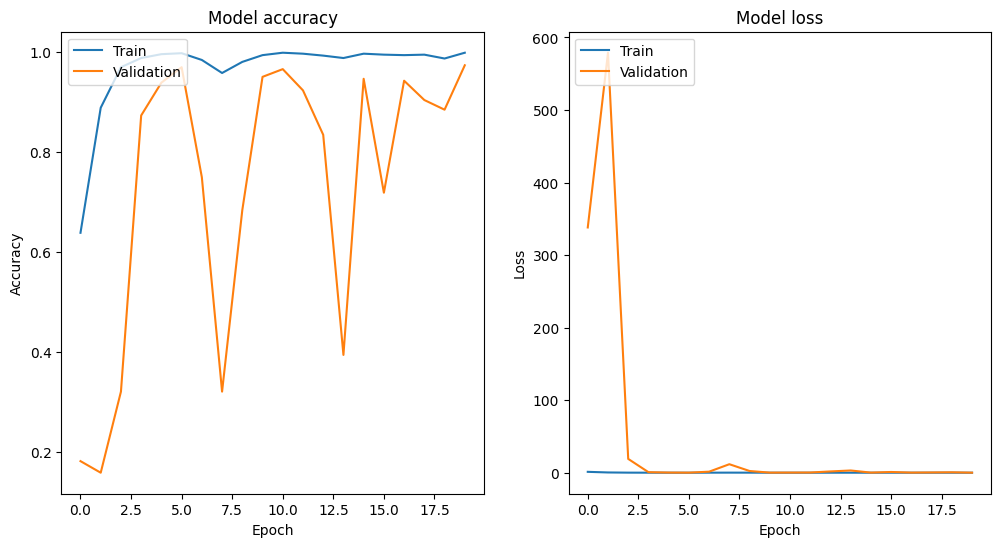

In [ ]:
import matplotlib.pyplot as plt

# Get the training history from the model training
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


14/14 [==============================] - 1s 91ms/step


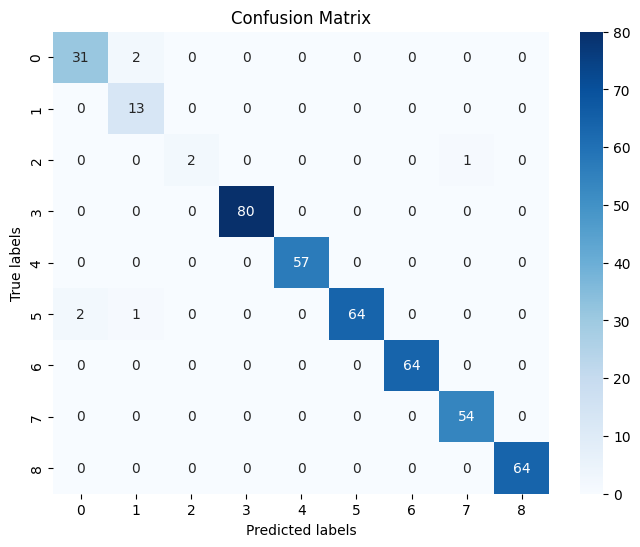

Precision: 0.9875417972831766
Recall: 0.9862068965517241
F1 Score: 0.9862653067234902
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.81      1.00      0.90        13
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        57
           5       1.00      0.96      0.98        67
           6       1.00      1.00      1.00        64
           7       0.98      1.00      0.99        54
           8       1.00      1.00      1.00        64

    accuracy                           0.99       435
   macro avg       0.97      0.95      0.96       435
weighted avg       0.99      0.99      0.99       435

Specificity: 0.9393939393939394


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


# Make predictions on the test set
y_pred_one_hot = model_resnet.predict(X_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
f1 = f1_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Display classification report
class_names = [str(i) for i in range(num_classes)]
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred, target_names=class_names))

TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

# VGG

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess data
def load_and_preprocess_data(data_directory):
    data = []    # To store images
    labels = []  # To store labels
    classes = 9  # Number of classes for traffic signs (0 to 8)

    for i in range(classes):
        path = os.path.join(data_directory, str(i))
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path, -1)
            image = cv2.resize(image, (224, 224))  # Resize images for VGG
            data.append(image)
            labels.append(i)

    # Convert the lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# File locations for training and testing data
train_data_directory = '/content/drive/MyDrive/Indian Dataset/Train'
test_data_directory = '/content/drive/MyDrive/Indian Dataset/Test'

# Load and preprocess training data
X_train, y_train = load_and_preprocess_data(train_data_directory)

# Load and preprocess testing data
X_test, y_test = load_and_preprocess_data(test_data_directory)

# Assuming you have 9 classes for traffic signs (0 to 8)
num_classes = 9

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Split training data into training and validation sets
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42
)

# Load the pretrained VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Remove the fully connected layers
x = base_model.output
x = Flatten()(x)

# Add a new classification layer for 10 classes
predictions = Dense(num_classes, activation='softmax')(x)

# Create the updated model
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an appropriate optimizer and loss function
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_vgg.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/drive/MyDrive/split_dataset_/model_vgg.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_vgg', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

# Train the model with the defined callbacks
history = model_vgg.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_val, y_val_one_hot), callbacks=callbacks)

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 16s 373ms/step - loss: 10.0284 - accuracy: 0.6226 - val_loss: 1.5316 - val_accuracy: 0.8880
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.9353
Epoch 2: val_loss improved from 1.53162 to 0.94748, saving model to /content/drive/MyDrive/split_dataset_/model_vgg.h5
33/33 [==============================] - 9s 263ms/step - loss: 0.9317 - accuracy: 0.9353 - val_loss: 0.9475 - val_accuracy: 0.9266
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.9614
Epoch 3: val_loss did not improve from 0.94748
33/33 [==============================] - 9s 277ms/step - loss: 0.3579 - accuracy: 0.9614 - val_loss: 1.2943 - val_accuracy: 0.9151
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9797
Epoch 4: val_loss improved from 0.94748 to 0.49085, saving model to /content/drive/MyDrive/split_dataset_/model_vgg.h5
33/33 [==============================]

In [ ]:
# Evaluate the model
test_loss, test_acc = model_vgg.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

14/14 [==============================] - 4s 293ms/step - loss: 2.1416 - accuracy: 0.9540
Test accuracy: 0.954023003578186
Test loss: 2.1416099071502686


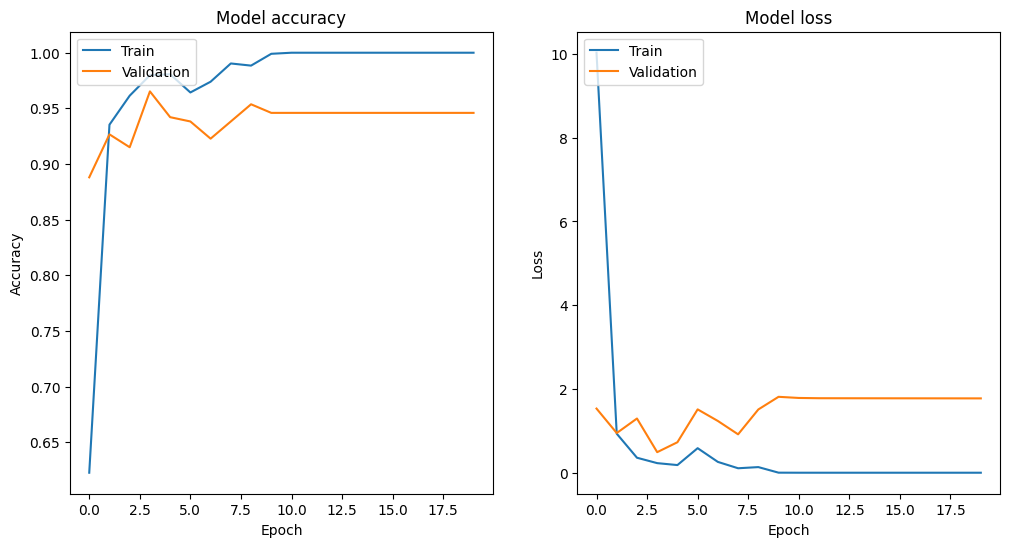

In [ ]:
import matplotlib.pyplot as plt

# Get the training history from the model training
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


14/14 [==============================] - 2s 119ms/step


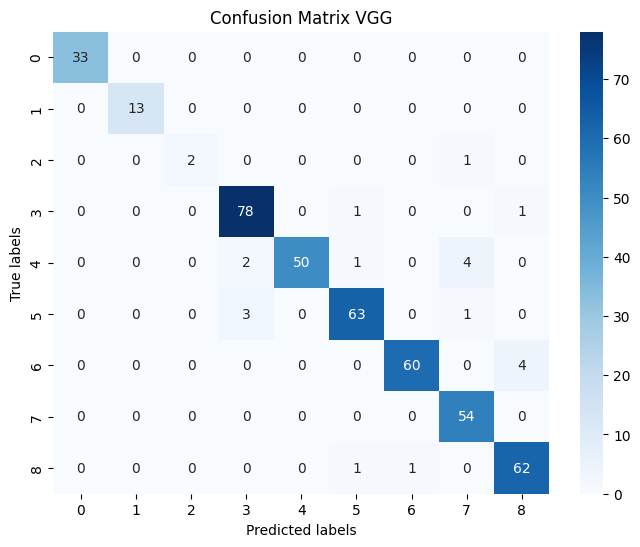

Precision: 0.9561148703799032
Recall: 0.9540229885057471
F1 Score: 0.953763624906716
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        13
           2       1.00      0.67      0.80         3
           3       0.94      0.97      0.96        80
           4       1.00      0.88      0.93        57
           5       0.95      0.94      0.95        67
           6       0.98      0.94      0.96        64
           7       0.90      1.00      0.95        54
           8       0.93      0.97      0.95        64

    accuracy                           0.95       435
   macro avg       0.97      0.93      0.94       435
weighted avg       0.96      0.95      0.95       435

Specificity: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


# Make predictions on the test set
y_pred_one_hot = model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix VGG')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
f1 = f1_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Display classification report
class_names = [str(i) for i in range(num_classes)]
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred, target_names=class_names))

TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

# CNN

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess data
def load_and_preprocess_data(data_directory):
    data = []    # To store images
    labels = []  # To store labels
    classes = 9  # Number of classes for traffic signs (0 to 8)

    for i in range(classes):
        path = os.path.join(data_directory, str(i))
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path, -1)
            image = cv2.resize(image, (30,30))  # Resize images for CNN
            data.append(image)
            labels.append(i)

    # Convert the lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# File locations for training and testing data
train_data_directory = '/content/drive/MyDrive/Indian Dataset/Train'
test_data_directory = '/content/drive/MyDrive/Indian Dataset/Test'

# Load and preprocess training data
X_train, y_train = load_and_preprocess_data(train_data_directory)

# Load and preprocess testing data
X_test, y_test = load_and_preprocess_data(test_data_directory)

# Assuming you have 9 classes for traffic signs (0 to 8)
num_classes = 9

# Convert the labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Split training data into training and validation sets
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(
    X_train, y_train_one_hot, test_size=0.2, random_state=42
)

# Build the CNN model
model_cnn = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(
            32, (3,3), activation = "relu" ,input_shape = (30, 30, 3)
        ),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(
            32, (3,3), activation = "relu" ,input_shape = (30, 30, 3)
        ),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(9, activation = "softmax"),
    ])

# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_cnn.summary()

# Train the model
epochs = 20
batch_size = 32

callbacks = [
    ModelCheckpoint('/content/drive/MyDrive/split_dataset_/model_cnn.h5', save_best_only=True, verbose=1),  # Save the best model checkpoint
    TensorBoard(log_dir='./logs_cnn', histogram_freq=1, write_graph=True, write_images=True)  # TensorBoard for visualization
]

# Train the model with the defined callbacks
history = model_cnn.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs,
                         validation_data=(X_val, y_val_one_hot), callbacks=callbacks)

# Evaluate the model
test_loss, test_acc = model_cnn.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               589952    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 5s 66ms/step - loss: 16.1871 - accuracy: 0.1950 - val_loss: 1.8765 - val_accuracy: 0.3282
Epoch 2/20
23/33 [===================>..........] - ETA: 0s - loss: 1.8191 - accuracy: 0.3628
Epoch 2: val_loss improved from 1.87645 to 1.57800, saving model to /content/drive/MyDrive/split_dataset_/model_cnn.h5
33/33 [==============================] - 2s 54ms/step - loss: 1.7324 - accuracy: 0.3871 - val_loss: 1.5780 - val_accuracy: 0.5097
Epoch 3/20
27/33 [=======================>......] - ETA: 0s - loss: 1.3208 - accuracy: 0.5567
Epoch 3: val_loss improved from 1.57800 to 0.97023, saving model to /content/drive/MyDrive/split_dataset_/model_cnn.h5
33/33 [==============================] - 1s 25ms/step - loss: 1.3110 - accuracy: 0.5589 - val_loss: 0.9702 - val_accuracy: 0.6718
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.6950
Epoch 4: val_loss improved from 0.97023 to 0.87634, saving model to /content/drive/MyDriv

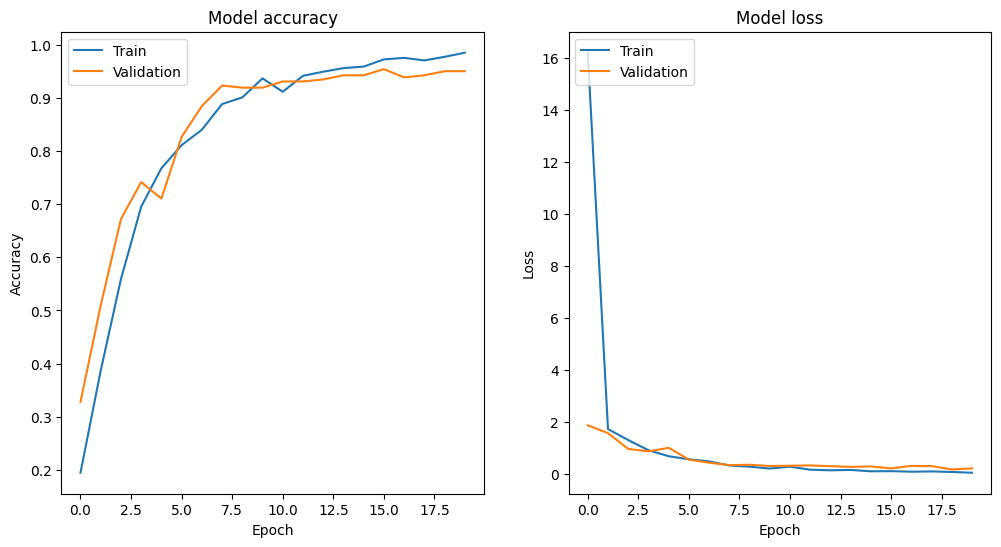

In [ ]:
import matplotlib.pyplot as plt

# Get the training history from the model training
history_dict = history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


14/14 [==============================] - 0s 3ms/step


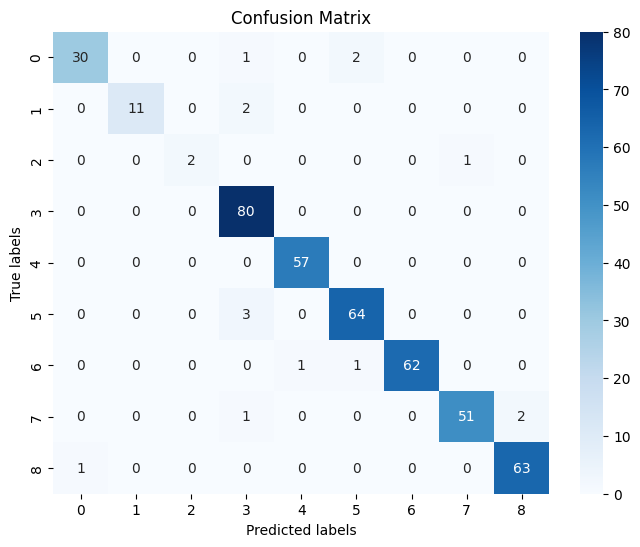

Precision: 0.9666856352491733
Recall: 0.9655172413793104
F1 Score: 0.9652028508543151
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       1.00      0.85      0.92        13
           2       1.00      0.67      0.80         3
           3       0.92      1.00      0.96        80
           4       0.98      1.00      0.99        57
           5       0.96      0.96      0.96        67
           6       1.00      0.97      0.98        64
           7       0.98      0.94      0.96        54
           8       0.97      0.98      0.98        64

    accuracy                           0.97       435
   macro avg       0.98      0.92      0.94       435
weighted avg       0.97      0.97      0.97       435

Specificity: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


# Make predictions on the test set
y_pred_one_hot = model_cnn.predict(X_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
recall = recall_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')
f1 = f1_score(np.argmax(y_test_one_hot, axis=1), y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Display classification report
class_names = [str(i) for i in range(num_classes)]
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred, target_names=class_names))

TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")